In [7]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


In [8]:
# data itself
url = 'lending_club_loan_two.csv'
# description of each column
url_info = 'lending_club_info.csv'
df_before = pd.read_csv(url)
df_info = pd.read_csv(url_info)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [9]:
# Create a new DataFrame for 'issue_d'
df_before_issue = df_before['issue_d'].str.split('-', expand=True)
df_before_issue.columns = ['issue_month', 'issue_year']

# Create a new DataFrame for 'earliest_cr_line'
df_before_cr_line = df_before['earliest_cr_line'].str.split('-', expand=True)
df_before_cr_line.columns = ['cr_line_month', 'cr_line_year']

# Concatenate the new DataFrames with the original DataFrame
df_before = pd.concat([df_before, df_before_issue, df_before_cr_line], axis=1)
# Reason:
# These features lack direct relevance to a person's ability to secure a loan. 
# grade and subgrade, summarizes the loan status, can be substituted with existing data like interest rates and annual income

columns_to_drop = ['emp_title', 'address', 'title', 'earliest_cr_line', 'issue_d', 'grade', 'sub_grade', 'purpose','initial_list_status']
df_before = df_before.drop(columns=columns_to_drop)

In [10]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['loan_status'] = le.fit_transform(df_before['loan_status'])
# 'Charged Off' = 0, 'Fully Paid' = 1 

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2

df_before['cr_line_month'] = le.fit_transform(df_before['cr_line_month'])
df_before['issue_month'] = le.fit_transform(df_before['issue_month'])
# df_before['initial_list_status'] = le.fit_transform(df_before['initial_list_status'])

In [11]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [12]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info = {}

for col in z_score_vars:
    # since our dataset is skewed we use the 99 percentile formula to detect and delete outliers, only identifying extreme datas
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)

    # Count outliers before clipping
    outlier_count = ((df_before[col] < lower_limit) | (df_before[col] > upper_limit)).sum()
    total_count = len(df_before[col])
    outlier_percentage = outlier_count / total_count * 100

    # Store outlier information for the column
    outlier_info[col] = {'count': outlier_count, 'percentage': outlier_percentage}

# Print outlier information for each column
print("Outlier information:")
for col, info in outlier_info.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")

# Drop rows with outliers
for col in z_score_vars:
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)
    no_outlier = no_outlier[(no_outlier[col] >= lower_limit) & (no_outlier[col] <= upper_limit)]

Outlier information:
- loan_amnt: 4089 outliers (1.03%)
- int_rate: 7823 outliers (1.98%)
- installment: 7916 outliers (2.00%)
- annual_inc: 7237 outliers (1.83%)
- dti: 7905 outliers (2.00%)
- open_acc: 5372 outliers (1.36%)
- pub_rec: 2543 outliers (0.64%)
- revol_bal: 7918 outliers (2.00%)
- total_acc: 7553 outliers (1.91%)


In [13]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier.columns[no_outlier.columns != target_column]

X = no_outlier[feature_columns]
y = no_outlier[target_column]

In [14]:
# use the pareto priuncple 
# split 80 train 10 validate 10 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
data_counts = y_train.value_counts()
print(data_counts)

loan_status
1    225416
0     54117
Name: count, dtype: int64


In [17]:
# Hyper Paramaters:
# n estimator (value to be determined by using a for loop while checking  accuracy score)
# bootstrap value true (to validate test result by using selecting random data)
# criterion value gini (Computational Efficiency as we have a large dataset and is less sensitive to outliers)
# max depth value none( to use all variables as it is currently not overfitting)
# max features value all/auto (use all to diversify tree, create more robust)

clf = RandomForestClassifier(n_estimators=83, bootstrap=True, criterion='gini', max_depth=None,  random_state=0)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = clf.predict(X_test)

# Evaluate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')


Test Accuracy: 0.8059641691946654


In [18]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 1049 12590]
 [  970 55275]]


In [19]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.52      0.08      0.13     13639
  Fully Paid       0.81      0.98      0.89     56245

    accuracy                           0.81     69884
   macro avg       0.67      0.53      0.51     69884
weighted avg       0.76      0.81      0.74     69884



### F1 Score

In [16]:
TN, FP, FN, TP = cm.ravel()

# Calculate Accuracy
# (TP+TN)/total sample
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Precision
# TP/(TP+FP)
# Precision is a measure of the accuracy of positive predictions made by the model. It answers the question: "Of all the instances predicted as positive, how many were actually positive?"
precision = precision_score(y_test, y_pred_test)
print("Precision:", precision)

# Calculate Recall
# TP/(TP+FN)
# Recall measures the model's ability to identify all the positive instances correctly. It answers the question: "Of all the actual positive instances, how many were correctly predicted?"
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

# Calculate Specificity
# TN/(TN+FN)
# specificity measures the model's ability to identify negative instances correctly. It answers the question: "Of all the actual negative instances, how many were correctly predicted?"
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# Calculate F1 Score
# (2*Precision*Recall)/(Precision+Recall)
f1 = f1_score(y_test, y_pred_test)
print("F1 Score:", f1)

Accuracy: 0.8039036116993875
Precision: 0.8134329457878373
Recall: 0.9814561294337274
Specificity: 0.07170613681354938
F1 Score: 0.889580043188191


AUC Score: 0.6923905474639023


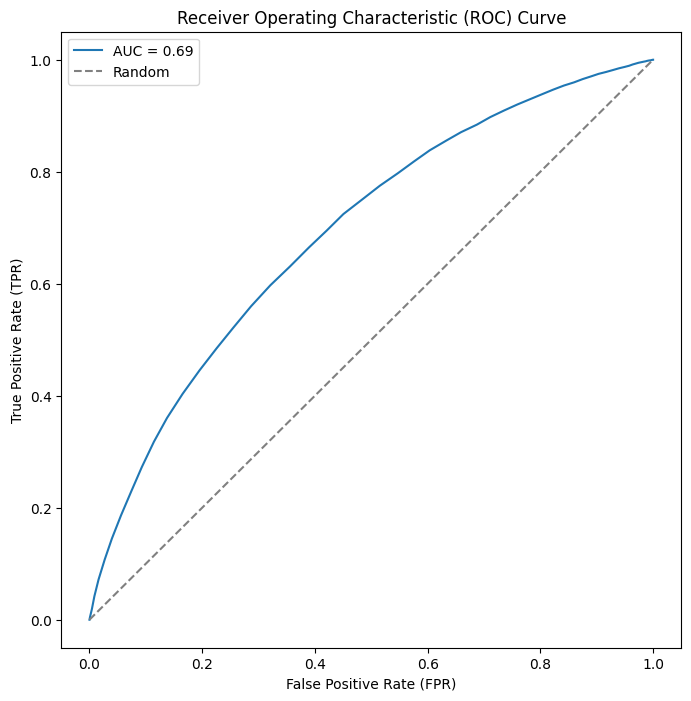

In [21]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# is 69 auc score good what does it mean, what can i do to increase it?

## Conclusion???

In [98]:
# Confusion Matrix BOTH OVER AND UNDER
# [[ 2836  3944]
#  [ 5103 23059]]
#              precision    recall  f1-score   support

#  Charged Off       0.36      0.43      0.39      6780
#   Fully Paid       0.85      0.81      0.83     28162

#     accuracy                           0.74     34942
#    macro avg       0.61      0.62      0.61     34942
# weighted avg       0.76      0.74      0.75     34942

# Accuracy: 0.7390819071604373
# Precision: 0.8548537357928079
# Recall: 0.8145728286343299
# Specificity: 0.42551622418879054
# F1 Score: 0.8342273214902631

# -----------------------------------------------------------

# Confusion Matrix OVERSAMPLING ONLY
#  [[ 1150  5630]
#  [ 1443 26719]]
#               precision    recall  f1-score   support
#  Charged Off       0.44      0.17      0.25      6780
#   Fully Paid       0.83      0.95      0.88     28162
#     accuracy                           0.80     34942
#    macro avg       0.63      0.56      0.56     34942
# weighted avg       0.75      0.80      0.76     34942

# Accuracy: 0.7975788449430484
# Precision: 0.8259606170206188
# Recall: 0.9487607414246148
# Specificity: 0.1696165191740413
# F1 Score: 0.8831121614251956

# Determining the better confusion matrix for loan approval depends on your priorities and the costs associated with different types of errors.

# Here's a breakdown of key metrics and considerations for each matrix:

# Matrix PT:

# Accuracy: 74%
# Precision (Charged Off): 35%
# Recall (Charged Off): 38%
# F1-score (Charged Off): 36%
# Strengths: Better at identifying charged-off loans (higher recall), potentially reducing losses from defaults.
# Weaknesses: Lower overall accuracy and precision, potentially leading to missed opportunities for good loans.
# Matrix ALP:

# Accuracy: 80%
# Precision (Charged Off): 44%
# Recall (Charged Off): 17%
# F1-score (Charged Off): 25%
# Strengths: Higher overall accuracy, approves more loans, and potentially increases profits.
# Weaknesses: Misses more charged-off loans (lower recall), potentially increasing losses from defaults.
# Considerations:

# Cost of False Negatives (Charged Off): If approving a charged-off loan is very costly, prioritize recall and lean towards PT.
# Cost of False Positives (Fully Paid): If denying a fully paid loan incurs significant opportunity costs, prioritize precision and lean towards ALP.
# Risk Tolerance: If risk tolerance is low, ALP might be preferred due to higher overall accuracy.
# Business Objectives: Balance profit goals with credit risk management.
# Additional Insights:

# F1-score: Consider this as a balanced measure of precision and recall, especially for the "Charged Off" class.
# Cost-Sensitive Analysis: Assign specific costs to each type of error to make a more informed decision.
# Explore Alternative Models: Investigate other models that might achieve a better balance between accuracy, precision, and recall for your specific needs.
# Ultimately, the best choice depends on your specific business context and risk tolerance.